In [1]:
from ooipy.request.hydrophone_request import get_acoustic_data_LF
from datetime import datetime
from pathlib import Path
import soundfile as sf
import matplotlib.pyplot as plt
import hvplot.xarray

In [2]:
node = 'AXEC2'

In [3]:
starttime=datetime(2025,1,5)
endtime=datetime(2025,1,6)

In [4]:
node_dict = {'AXEC2': 'RS03ECAL-MJ03E-09-HYDLFA304'}

In [5]:
refdes = node_dict[node]
refdes

'RS03ECAL-MJ03E-09-HYDLFA304'

In [6]:
date_str = datetime.strftime(starttime, "%Y_%m_%d")
date_str

'2025_01_05'

In [7]:
LF_data = get_acoustic_data_LF(
    starttime=starttime,
    endtime=endtime,
    node=node,
    verbose=True,
)   

In [8]:
LF_data

OO.AXEC2.AXEC2.HDH | 2025-01-05T00:00:00.000000Z - 2025-01-06T00:00:00.001592Z | 200.0 Hz, 17280000 samples

In [20]:
spec = LF_data.compute_spectrogram(L=2048, avg_time=20, verbose=True,)

In [21]:
spec

<xarray.DataArray 'spectrogram' (time: 4320, frequency: 1025)>
array([[59.70430255, 73.13122569, 85.10182981, ..., 11.40386426,
        18.18192727, 18.91566895],
       [67.87039372, 68.60820986, 83.26870282, ..., 19.8520473 ,
        22.65886614, 18.6093989 ],
       [82.64980461, 84.17115835, 82.55737664, ..., 22.0394896 ,
        21.12252736,  6.62301433],
       ...,
       [59.09595367, 69.14061012, 80.66496898, ..., 18.24633491,
        19.2136544 , 17.55383497],
       [63.44644375, 65.68388561, 80.24773311, ..., 20.19579559,
        21.11863554, 17.33388547],
       [62.17365143, 67.4995344 , 76.13430069, ..., 17.47352875,
        21.56285375, 14.78184895]])
Coordinates:
  * time       (time) datetime64[ns] 2025-01-05 ... 2025-01-05T23:59:40
  * frequency  (frequency) float64 0.0 0.09766 0.1953 0.293 ... 99.8 99.9 100.0
Attributes:
    start_time:  2025-01-05 00:00:00
    end_time:    2025-01-06 00:00:00.001592
    nperseg:     2048
    units:       dB rel µ Pa^2 / Hz

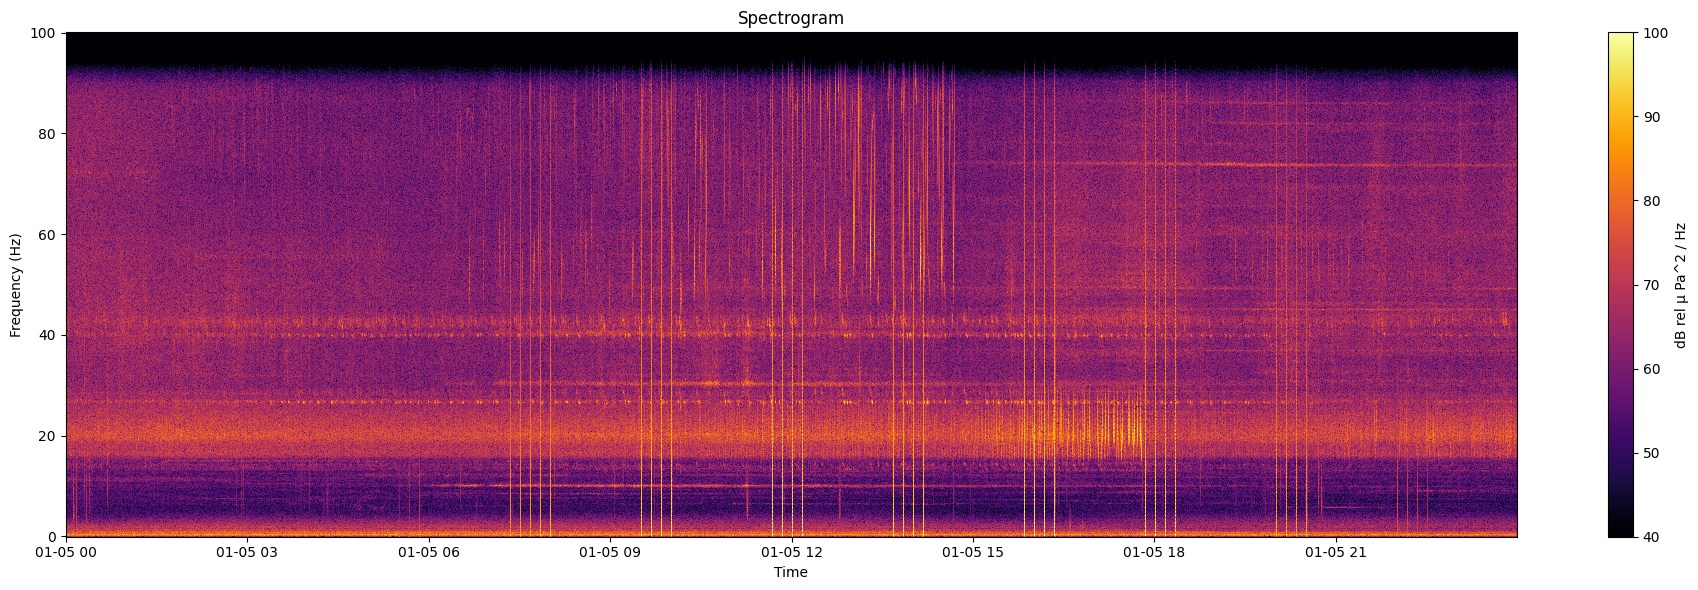

In [42]:
plt.figure(figsize=(19, 6))
pcm = plt.pcolormesh(
    spec['time'],
    spec['frequency'],
    spec.T,                        # Transpose so shape is [frequency, time]
    shading='auto',
    vmin=40,
    vmax=100,# Avoid warning about dimension mismatch
    cmap='inferno'              # You can use 'plasma', 'inferno', 'magma', etc.
)
plt.colorbar(pcm, label=spec.attrs.get("units"))
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
plt.title("Spectrogram")
plt.tight_layout()
plt.show()

In [79]:
flac_dir = Path.cwd() / f"data/flac/{date_str}/{refdes[18:]}"

In [80]:
flac_dir.mkdir(parents=True, exist_ok=True)

In [81]:
st = LF_data

In [82]:
st.stats

         network: OO
         station: AXEC2
        location: AXEC2
         channel: HDH
       starttime: 2025-01-05T00:00:00.000000Z
         endtime: 2025-01-06T00:00:00.001592Z
   sampling_rate: 199.9999847412109
           delta: 0.005000000381469756
            npts: 17280000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'M', 'number_of_records': 50479, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 25845248})

In [83]:
len(st.data)

17280000

In [97]:
len(st.data) / st.stats.sampling_rate 

86400.00659179738

In [85]:
start_time = str(st.stats["starttime"])
sr = int(round(st.stats["sampling_rate"]))
dt = datetime.strptime(start_time, "%Y-%m-%dT%H:%M:%S.%fZ")

new_format = dt.strftime("%Y%m%d_%H%M%S")  # dt.strftime("%y%m%d%H%M%S%z")

flac_path = flac_dir / f"{refdes[-9:]}_{new_format}.flac"

In [86]:
print(start_time)
print(sr)
print(flac_path)

2025-01-05T00:00:00.000000Z
200
/Users/joeduprey/repos/ooi-hyd-tools/notebooks/data/flac/2025_01_05/HYDLFA304/HYDLFA304_20250105_000000.flac


In [87]:
sf.write(flac_path, st.data, sr, subtype='PCM_24')

In [88]:
pwd

'/Users/joeduprey/repos/ooi-hyd-tools/notebooks'